In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-03-24 01:18:22--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0s      

2020-03-24 01:18:22 (145 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



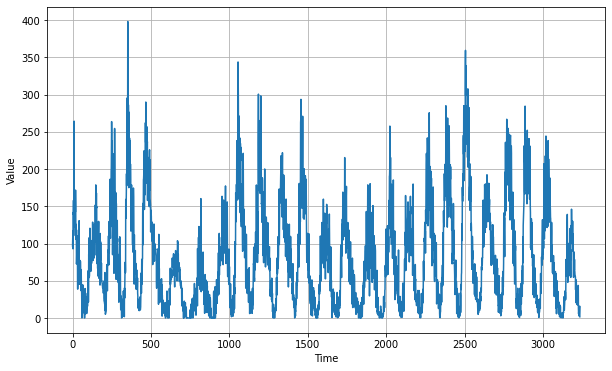

In [ ]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

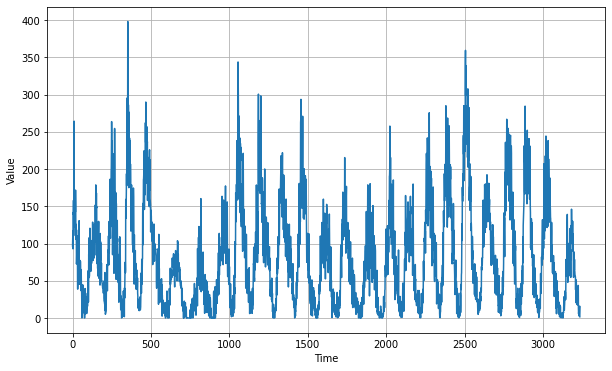

In [ ]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 9s 777ms/step - loss: 80.2708 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 1s 46ms/step - loss: 78.2509 - mae: 78.5896
Epoch 3/100
12/12 [==============================] - 1s 49ms/step - loss: 75.6613 - mae: 75.9445
Epoch 4/100
12/12 [==============================] - 1s 47ms/step - loss: 72.3021 - mae: 72.7693
Epoch 5/100
12/12 [==============================] - 1s 48ms/step - loss: 69.0174 - mae: 69.2661
Epoch 6/100
12/12 [==============================] - 1s 49ms/step - loss: 65.3797 - mae: 65.6140
Epoch 7/100
12/12 [==============================] - 1s 48ms/step - loss: 61.9061 - mae: 62.0189
Epoch 8/100
12/12 [==============================] - 1s 48ms/step - loss: 58.0653 - mae: 58.6465
Epoch 9/100
12/12 [==============================] - 1s 51ms/step - loss: 55.4543 - mae: 55.5682
Epoch 10/100
12/12 [====

(1e-08, 0.0001, 0.0, 60.0)

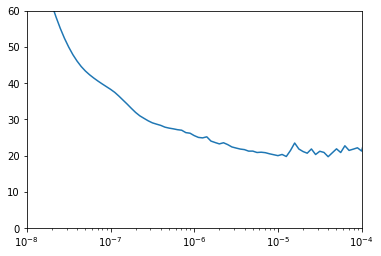

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 3s 95ms/step - loss: 37.8967 - mae: 38.6059
Epoch 2/500
30/30 [==============================] - 1s 23ms/step - loss: 24.0765 - mae: 24.6132
Epoch 3/500
30/30 [==============================] - 1s 24ms/step - loss: 22.0137 - mae: 22.5107
Epoch 4/500
30/30 [==============================] - 1s 23ms/step - loss: 19.8705 - mae: 20.3480
Epoch 5/500
30/30 [==============================] - 1s 24ms/step - loss: 19.6901 - mae: 20.1878
Epoch 6/500
30/30 [==============================] - 1s 23ms/step - loss: 19.3893 - mae: 19.8872
Epoch 7/500
30/30 [==============================] - 1s 23ms/step - loss: 18.8501 - mae: 19.3395
Epoch 8/500
30/30 [==============================] - 1s 25ms/step - loss: 18.4665 - mae: 18.9783
Epoch 9/500
30/30 [==============================] - 1s 24ms/step - loss: 18.2267 - mae: 18.6929
Epoch 10/500
30/30 [==============================] - 1s 24ms/step - loss: 18.1388 - mae: 18.6074
Epoch 11/500
30/30 [=========

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

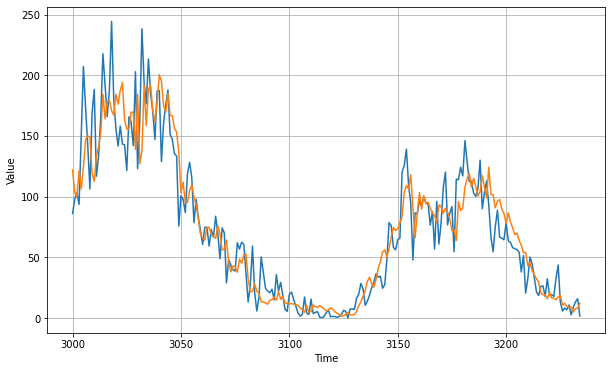

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.5805435

<Figure size 432x288 with 0 Axes>

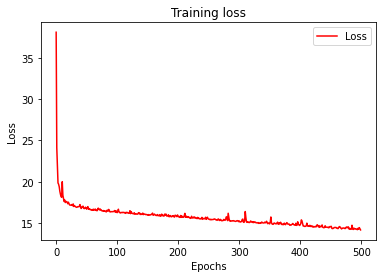

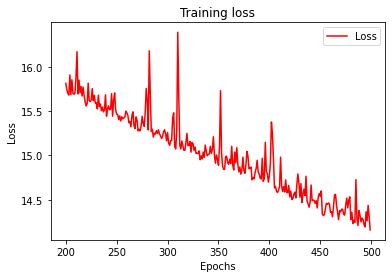

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)

[121.9261    102.994965  100.08023   121.21126   106.285774  124.427605
 146.9598    150.18771   148.66031   119.071686  112.51642   133.3904
 140.81142   152.52551   184.45786   164.08507   178.20067   179.2509
 170.76042   167.07167   184.3833    176.17697   187.478     193.99854
 163.06274   155.71664   156.0732    169.43913   169.66658   138.82495
 184.21971   127.16475   137.52217   191.85052   158.55951   188.08684
 191.96059   171.08472   161.5912    178.04149   200.38275   195.04683
 174.65013   169.69363   185.15208   167.01842   166.61224   156.24721
 153.19298   136.94261   102.911674  111.86479    95.20241    95.162186
 105.29851   109.4617     99.72882    93.09534    82.08425    68.7227
  66.07425    63.973724   74.42275    74.69893    68.99996    66.93427
  65.65604    75.84805    69.7443     55.97707    56.732666   64.24067
  45.893185   37.985546   42.90219    42.166843   37.64952    48.474808
  44.96517    51.621902   52.722992   31.954187   21.551937   21.929026
  28.